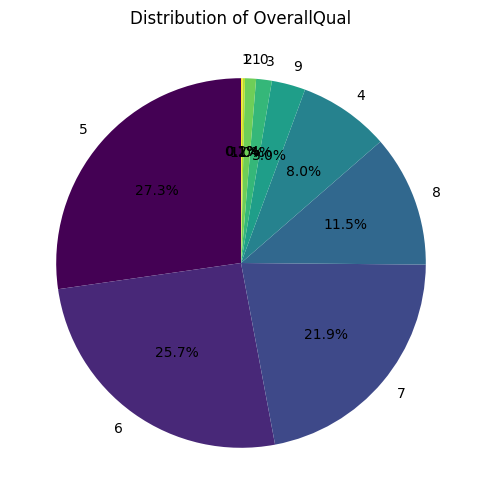

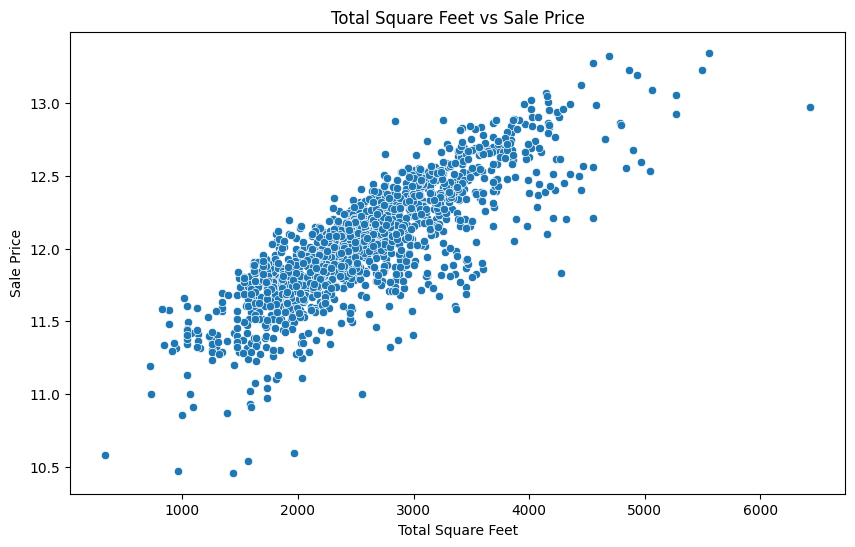

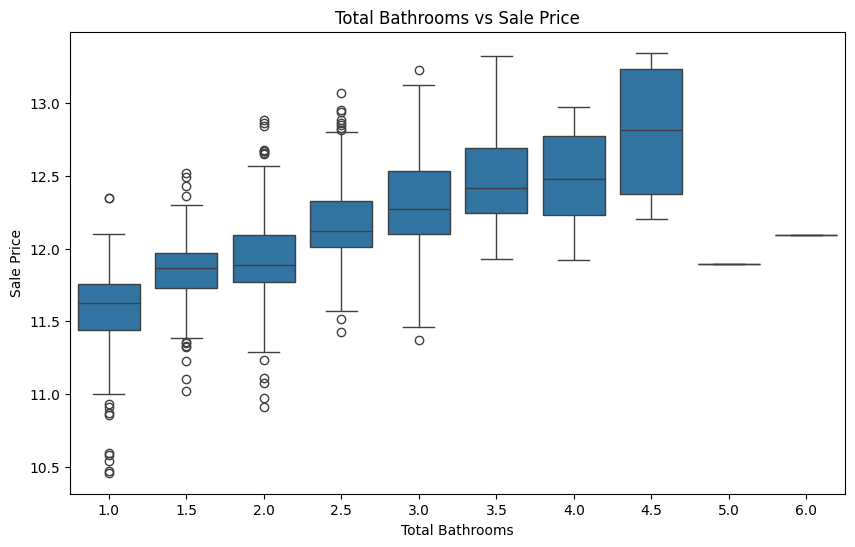

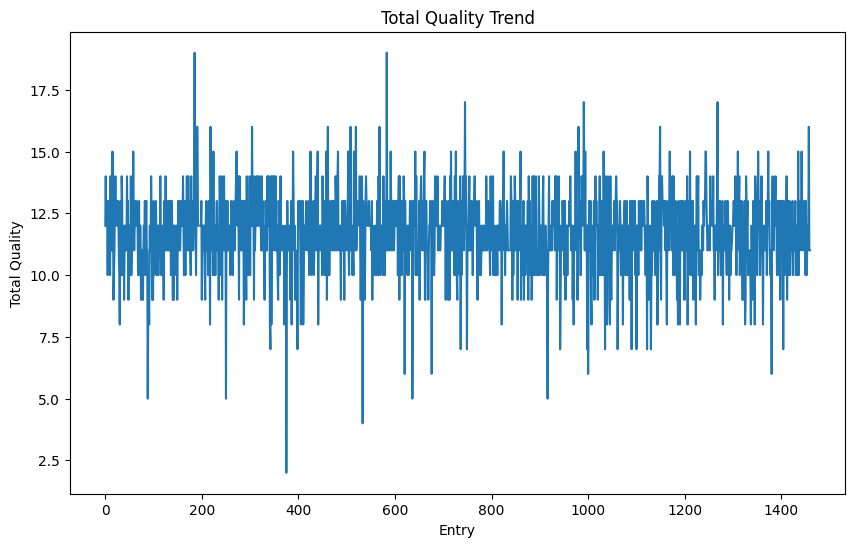

+--------------------------------+---------------------+
|             Metric             |        Value        |
+--------------------------------+---------------------+
| Root Mean Squared Error (RMSE) | 0.14422559916188354 |
+--------------------------------+---------------------+
+--------+--------------------+
|   Id   |     SalePrice      |
+--------+--------------------+
| 1461.0 | 128252.4794125133  |
| 1462.0 | 163353.14012313887 |
| 1463.0 | 175886.75689899828 |
| 1464.0 | 184301.5089576581  |
| 1465.0 | 192977.1363992519  |
+--------+--------------------+


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

df_train = df_train.drop(df_train[df_train['GrLivArea'] > 4000].index)
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_train = df_train.dropna(subset=['SalePrice'])

df_train['Total_SF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['Total_Bathrooms'] = (df_train['FullBath'] + (0.5 * df_train['HalfBath']) + df_train['BsmtFullBath'] + (0.5 * df_train['BsmtHalfBath']))
df_train['Total_Porch_SF'] = (df_train['OpenPorchSF'] + df_train['3SsnPorch'] + df_train['EnclosedPorch'] + df_train['ScreenPorch'] + df_train['WoodDeckSF'])
df_train['Total_Square_Feet'] = (df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['1stFlrSF'] + df_train['2ndFlrSF'])
df_train['Total_Quality'] = df_train['OverallQual'] + df_train['OverallCond']

df_train = pd.get_dummies(df_train, drop_first=True)
df_train.fillna(df_train.median(), inplace=True)

X = df_train.drop(['SalePrice'], axis=1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

for col in df_test.columns:
    if df_test[col].dtype == 'object':
        df_test[col].fillna(df_test[col].mode()[0], inplace=True)
    else:
        df_test[col].fillna(df_test[col].median(), inplace=True)

df_test['Total_SF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['Total_Bathrooms'] = (df_test['FullBath'] + (0.5 * df_test['HalfBath']) + df_test['BsmtFullBath'] + (0.5 * df_test['BsmtHalfBath']))
df_test['Total_Porch_SF'] = (df_test['OpenPorchSF'] + df_test['3SsnPorch'] + df_test['EnclosedPorch'] + df_test['ScreenPorch'] + df_test['WoodDeckSF'])
df_test['Total_Square_Feet'] = (df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] + df_test['1stFlrSF'] + df_test['2ndFlrSF'])
df_test['Total_Quality'] = df_test['OverallQual'] + df_test['OverallCond']

df_test = pd.get_dummies(df_test, drop_first=True)

missing_cols = set(X.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0
df_test = df_test[X.columns]

X_test = scaler.transform(df_test)

predictions = model.predict(X_test)

submit = pd.DataFrame()
submit['Id'] = df_test.index + 1461
submit['SalePrice'] = np.exp(predictions)
submit.to_csv('submission.csv', index=False)

plt.figure(figsize=(8, 6))
df_train['OverallQual'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribution of OverallQual')
plt.ylabel('')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_SF', y='SalePrice', data=df_train)
plt.title('Total Square Feet vs Sale Price')
plt.xlabel('Total Square Feet')
plt.ylabel('Sale Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Total_Bathrooms', y='SalePrice', data=df_train)
plt.title('Total Bathrooms vs Sale Price')
plt.xlabel('Total Bathrooms')
plt.ylabel('Sale Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=df_train.index, y='Total_Quality', data=df_train)
plt.title('Total Quality Trend')
plt.xlabel('Entry')
plt.ylabel('Total Quality')
plt.show()

rmse_table = pd.DataFrame({'Metric': ['Root Mean Squared Error (RMSE)'], 'Value': [rmse]})
print(tabulate(rmse_table, headers='keys', tablefmt='pretty', showindex=False))

sample_submission_table = submit.head()
print(tabulate(sample_submission_table, headers='keys', tablefmt='pretty', showindex=False))
